<p align="center">
    <img src="https://ars.els-cdn.com/content/image/3-s2.0-B9780081002858000055-f05-13-9780081002858.jpg" width="220" height="240" />

</p>

# Exploratory Data Analysis - Rod Pump Optimization

## Inventors Program Energy - NSC 325

#### Written by: Nicholas Khami, Nashra Ali, Vrishank Jannu

This paper is a documentation of research using data provided by ConocoPhillips aiming to better predict sucker rod pump failure. In analyzing the data and discovering which parameters are most influential in causing a rod pump to fail, we will be able to hypothesize a better design for the downhole set-up in order to expand pump lifetimes. This in turn will cut yearly maintainence, i.e. part replacement, costs for the company, and increase oil production per well. As a result, the company would be able to enjoy a higher return on their investments. The audience for this notebook is ConocoPhillips data scientists. 


### Part 1: Setup

#### Import Libraries

In [471]:
import glob
import pandas as pd
import numpy as np
from scipy import stats
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#### Import Data

To begin approaching the problem, it is important to get a feel for the data that we will be working with. The following code displays the head of the data and dataframe properties. The data documents parameters of various wells owned by ConocoPhillips. We are doing this primarily to get a rough idea of the data so that we can begin making our hypotheses.

In [472]:
rpdf = pd.read_csv("../UT_RodPump_Dataset/rodpump_failure.csv")
rpdf[rpdf == 0] = np.nan
rpdf.head()

roduid          UWI              NODEID  \
0  GB27GKBE51029074693667  175-58-0111    box-child-doctor   
1  GB53OEVX46438297645035  333-68-3523       outside-worry   
2  GB95BPWW35640301552066  165-51-5897   near-learn-simply   
3  GB79UEDN31454825972680  543-56-3494   sea-improve-place   
4  GB20XCTM13691331349509  391-37-2039  personal-candidate   

               IDWELL                  tbguid           lifetime_start  \
0  GPVO63973435661154  GB55QFGB46756147811400  2014-05-02 00:00:00.000   
1  ZAYT33358197650329  GB29QCCC14341267287129  2018-01-28 14:00:00.000   
2  FNVL11432909873086  GB02DJAW44801752494129  2011-09-14 00:00:00.000   
3  JOKL33317998159514  GB84GHPH97287631470412  2016-01-12 09:00:00.000   
4  XOSU92041716672870  GB08VYTX61977431827206  2018-06-14 13:00:00.000   

              lifetime_end        IDRECJOBPULL         REPORTTO  \
0  2019-01-04 10:00:00.000  FGNB86581338411987           Tubing   
1  2019-05-17 12:00:00.000  XRYU81281518151403           Tubing   
2  2012-08-20 00:00:00.000  PLPR44121073149707  Sucker Rod Pump   
3  2017-03-16 16:30:00.000  MYCF04792093856141  Sucker Rod Pump   
4  2020-04-15 17:37:11.338  WJDB83445325478746              NaN   

                 FAILSTART      FAILURETYPE  H2S_CONCENTRATION  \
0  2018-12-11 00:00:00.000           Tubing                NaN   
1  2019-04-01 00:00:00.000           Tubing                NaN   
2  2012-08-01 00:00:00.000  Sucker Rod Pump                NaN   
3  2017-01-19 00:00:00.000  Sucker Rod Pump                NaN   
4                      NaN              NaN                NaN   

   PrimarySetpoint  SecondarySetpoint  StrokeLength  GrossStrokeLength  \
0               75                 60           144                108   
1               80                 62           168                173   
2               75                 60           144                NaN   
3               75                 60           144                NaN   
4               80                 65           168                127   

   Fillage  YesterdaysAverageSPM bha_configuration  chemgroup1_any  \
0       91                     6     TAC_ABOVE_NIP               1   
1        2                   NaN     TAC_BELOW_NIP               1   
2      NaN                   NaN     PACKER_DONNAN             NaN   
3       86                     6     TAC_ABOVE_NIP               1   
4       61                     4     TAC_BELOW_NIP               1   

   chemgroup1_all  chemgroup2_any  chemgroup2_all  chemgroup3_any  \
0               1               1               1             NaN   
1               1             NaN             NaN             NaN   
2             NaN             NaN             NaN             NaN   
3             NaN               1             NaN             NaN   
4             NaN             NaN             NaN             NaN   

   chemgroup3_all  max_unguided_dls  dls_high_in_hole  gas_anchor_length  \
0             NaN                 2                 1                 19   
1             NaN                 2                 2                 17   
2             NaN                 5                 5                 21   
3             NaN                 2                 0                 17   
4             NaN                 2                 4                 17   

   MAX_INCLINATION wellbore_category manual_scale packer_vs_tac  \
0                2          Vertical            N  OTHER_ANCHOR   
1                2          Vertical            N  OTHER_ANCHOR   
2                2          Vertical            N      arrowset   
3                1          Vertical            Y  OTHER_ANCHOR   
4                4        LowTangent            N  OTHER_ANCHOR   

   AVG_PRESS_FLOWLINE  AVG_PRESSURE_TUBING  AVG_PRESSURE_CASING  \
0                  60                   74                   53   
1                  54                   77                   88   
2                 NaN                   74                 

### Part 2: Get High Level DataFrame Information 

To continue exploring the data, we want to know how many features and observations we will be starting with. The following code prints the overall shape of the data to evaluate the counts later on. We will not neccesarily be using every column and every row going forth after cleaning the data and removing rows with too many missing values to be useful in our research.

In [473]:
rpdf.shape

(2596, 55)

The following code prints all of the columns so that we can get a rough idea for what features we will have to train on. We can now do research for parameter to get a better understanding of what each one means, as well as what units they are measured in. Moreover, looking at the list, we have a rough idea that based on FAILURETYPE, there will be different features that predict the lifespan of the well.

In [474]:
rpdf.columns

Index(['roduid', 'UWI', 'NODEID', 'IDWELL', 'tbguid', 'lifetime_start',
       'lifetime_end', 'IDRECJOBPULL', 'REPORTTO', 'FAILSTART', 'FAILURETYPE',
       'H2S_CONCENTRATION', 'PrimarySetpoint', 'SecondarySetpoint',
       'StrokeLength', 'GrossStrokeLength', 'Fillage', 'YesterdaysAverageSPM',
       'bha_configuration', 'chemgroup1_any', 'chemgroup1_all',
       'chemgroup2_any', 'chemgroup2_all', 'chemgroup3_any', 'chemgroup3_all',
       'max_unguided_dls', 'dls_high_in_hole', 'gas_anchor_length',
       'MAX_INCLINATION', 'wellbore_category', 'manual_scale', 'packer_vs_tac',
       'AVG_PRESS_FLOWLINE', 'AVG_PRESSURE_TUBING', 'AVG_PRESSURE_CASING',
       'AVG_DIFFERENTIAL_PRESSURE', 'AVG_OIL_VOLUME', 'AVG_WATER_VOLUME',
       'AVG_LIQUID_VOLUME', 'AVG_WATERSG', 'rod_sinker_type', 'rod_has_guides',
       'rod_make', 'rod_apigrade', 'ROUTE', 'overall_max_sideload',
       'shallow_max_sideload', 'max_unguided_sideload', 'DESANDDEGAS_TYP',
       'CHROME_LENGTH', 'ENDURALLOY_LEN

#### Analysis of Numeric DataFrame features

Here, we use describe() to get the count, mean, standard deviation, min, and max for numeric variables. This statistical summary allows us to calculate a range of plausible values for each parameter, which in particular, will also help us determine outliers. The code that follows is simply formatting the output. 

Heuristically, there are a few features that we think will be promising when training our model: AVG_LIQUID_VOLUME (oil and water), overall_max_sideload, shallow_max_sideload, max_unguided_sideload, NIPPLE_SET_DEPTH, and all of the average pressures. There were several features such as StrokeLength and Fillage that we thought may be good predictors of failure, but they lacked differentiation throughout the dataframe. 

We think that the features listed are promising because they have differentiation across their quartiles and strong representation throughout the dataframe. Additionally, we hypothesize that they will reflect overall stress on the Rod Pump.  

In [475]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', 55)
rpdf_numeric_summary = rpdf.describe()
print(rpdf_numeric_summary.shape)
rpdf_numeric_summary

(8, 34)


H2S_CONCENTRATION  PrimarySetpoint  SecondarySetpoint  StrokeLength  \
count                141             2586               2423          2588   
mean                 188               75                 61           149   
std                 1427                5                  3            13   
min                    0               20                 41            61   
25%                    2               75                 60           144   
50%                    5               75                 60           144   
75%                   13               75                 65           146   
max                16500               91                100           336   

       GrossStrokeLength  Fillage  YesterdaysAverageSPM  chemgroup1_any  \
count               1493     1938                  1792            1221   
mean                 131       84                     6               1   
std                   32       25                     1               0   
min                    0        0                     1               1   
25%                  115       76                     5               1   
50%                  129       87                     6               1   
75%                  147       95                     6               1   
max                  655      655                     8               1   

       chemgroup1_all  chemgroup2_any  chemgroup2_all  chemgroup3_any  \
count             218             606             224             174   
mean                1               1               1               1   
std                 0               0               0               0   
min                 1               1               1               1   
25%                 1               1               1               1   
50%                 1               1               1               1   
75%                 1               1               1               1   
max                 1               1               1               1   

       chemgroup3_all  max_unguided_dls  dls_high_in_hole  gas_anchor_length  \
count              82              2525              2512               2381   
mean                1                 3                 3                 19   
std                 0                 6                 6                  5   
min                 1                 0                 0                  1   
25%                 1                 1                 1                 17   
50%                 1                 2                 2                 19   
75%                 1                 3                 3                 21   
max                 1                92                92                 45   

       MAX_INCLINATION  AVG_PRESS_FLOWLINE  AVG_PRESSURE_TUBING  \
count             2538                1661                 2424   
mean                 5                  58                   90   
std                  6                  18                   62   
min                  1                   0                    0   
25%                  2                  50                   66   
50%                  2                  60                   80   
75%                  6                  67                  102   
max                 53                 248                 1485   

       AVG_PRESSURE_CASING  AVG_DIFFERENTIAL_PRESSURE  AVG_OIL_VOLUME  \
count                 2479                       2428            2553   
mean                   119                         32              83   
std                    106                        129              56   
min                      0                       -987               0   
25%                     68                         -3              44   
50%                     95                         16              73   
75%                    141                         52             110   
max                   2322                       4424        

#### Analysis of Non-Numeric DataFrame features

* During data cleanup, we will need to make lifetime_start and lifetime_end into one feature called "lifetime" to reduce the amount of features and thus have better model training 
* We anticipate that FAILSTART will also be incredibly important and must be turned into an int/float that is easier to train on
* We anticipate that FAILURETYPE will be incredibly important in terms of predicting FAILSTART. This is also suggested in previous rod pump failure analysis research. If we find that FAILURETYPE has strong correlation to FAILSTART then it may be better to predict FAILURETYPE than FAILSTART

In [476]:
rpdf_strobj_summary = rpdf.describe(include=['bool', 'object'])
print(rpdf_strobj_summary.shape)
rpdf_strobj_summary

(4, 21)


roduid          UWI               NODEID  \
count                     2596         2596                 2596   
unique                    2596          633                  632   
top     GB79GHCV65709580704411  540-51-3641  catch-gas-bill-cost   
freq                         1           15                   15   

                    IDWELL                  tbguid           lifetime_start  \
count                 2596                    2596                     2596   
unique                 633                    1815                     2408   
top     FOKS36813367797224  GB55DXHO49300642199527  2015-06-11 00:00:00.000   
freq                    15                       6                        4   

                   lifetime_end        IDRECJOBPULL REPORTTO  \
count                      2596                2596     1725   
unique                     1888                1693        4   
top     2020-04-15 17:37:11.338  WJDB83445325478746   Tubing   
freq                        591                 871      899   

                      FAILSTART FAILURETYPE bha_configuration  \
count                      1725        1721              2550   
unique                     1477           3                 5   
top     2013-03-01 00:00:00.000      Tubing     TAC_ABOVE_NIP   
freq                          6         899               914   

       wellbore_category manual_scale packer_vs_tac    rod_sinker_type  \
count               2591         2596          2582               2596   
unique                 4            2             5                  4   
top             Vertical            N  OTHER_ANCHOR  SLICK_SINKER_BARS   
freq                1647         2250          1634               1737   

                       rod_make    rod_apigrade DESANDDEGAS_TYP pump_bore  \
count                      2596            2591            2596      2596   
unique                        7               6               6         5   
top     mesh enterprise portals  SpecialService      Miller LLC      1.75   
freq                       1433            1695            1394      1074   

          gasanchor_od  
count             1488  
unique               4  
top     OtherOrUnknown  
freq               952

### Part 3: Basic Data Cleanup Steps 

* As part of our data analysis, we thought it would be important to see what our numeric database statistics look like when we remove NaN and zero values. In our intial scanning of the data, we realized that we had to be careful in which parameters we chose to do this; for example, the 0's in the hydrogen sulfide concentration column are inmportant as they do not represent missing data, and those rows with a non-zero value may have significant influence on rod pump lifetime (large H2S concentrations may indicate corrosion of a component).
* For the non-numeric columns, we wanted to see whether or not we could simplify any of the object/boolean columns

#### Feature Selection Based On Presence 

We wanted to get rid of any features that had less than 1660 rows of non-null values. 1660 was chosen based on looking at the the features that we thought we would be heuristically valuable. 

Removed Features: ```['H2S_CONCENTRATION', 'GrossStrokeLength', 'chemgroup1_any', 'chemgroup1_all', 'chemgroup2_any', 'chemgroup2_all', 'chemgroup3_any', 'chemgroup3_all', 'rod_has_guides', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od']```

In [477]:
rpdf_cleaned = rpdf.copy()
# Alternative Setup For Flexible Removal 
   # perc = 30.0 # Like N %
   # min_count =  int(((100-perc)/100)*rpdf.shape[0] + 1)
# Chosen Value based on uniques for heuristically useful features 
min_count = 1490
rpdf_cleaned = rpdf_cleaned.dropna(axis=1, thresh=min_count)

removed_columns = []
for column in rpdf.columns: 
   if(column not in rpdf_cleaned.columns): 
      removed_columns.append(column)

print(removed_columns)

['H2S_CONCENTRATION', 'GrossStrokeLength', 'chemgroup1_any', 'chemgroup1_all', 'chemgroup2_any', 'chemgroup2_all', 'chemgroup3_any', 'chemgroup3_all', 'rod_has_guides', 'CHROME_LENGTH', 'ENDURALLOY_LENGTH', 'POLY_LENGTH', 'gasanchor_od']


#### Remove Rows with 20 percent or more NaN values
As mentioned earlier, we decided that rows with 20 percent or more missing values would not be beneficial for our research as they provide little data for the model to train on. The following code achieves this.

In [478]:
rpdf_cleaned = rpdf_cleaned.dropna(axis=0, thresh=8)
print((str)(rpdf.shape[0] - rpdf_cleaned.shape[0]) + ' rows were removed out of ' + (str)(rpdf.shape[0]))
rpdf_cleaned.shape

198 rows were removed out of 2596


(2398, 42)

#### Remove Outliers

* At this step we chose to drop the following features: ```['PrimarySetpoint', 'AVG_WATERSG']``` because they consisted of only outliers 
* We think that this requires more detailed tuning by changing the multiplication factor for iqr based on the specific variance of each feature

In [479]:
def remove_outlier(df_in, col_name):
    # print(column)
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-7*iqr
    fence_high = q3+7*iqr
    df_out = df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    # print(df_out.shape)
    return df_out

rpdf_cleaned.drop(columns=['PrimarySetpoint', 'AVG_WATERSG'], inplace=True)

for column in rpdf_cleaned.columns: 
   if(rpdf_cleaned.dtypes[column] in [np.int64, np.float64]): 
        rpdf_cleaned = remove_outlier(rpdf_cleaned, column)
      
rpdf_cleaned.shape

(832, 40)

### Part 4: Visualize Data

#### Calculate Correlation Matrix
To begin visualizng the data, we did a bivariate analysis with each pair of parameters to determine their relationship with each other so that we could drop some features in model training. This was achieved by doing scatterplots and a heatmap, both which show how strongly a variable correlates with another. It appears that average oil volume, average liquid volume, and average water volume have high correlations to each other, so we can drop two of the variables when training our model. Overall max sideload and shallow max sideload also have a high correlation coefficient, so one of them may be dropped when training the model.

* Note: It would be great to encode the Strings for FailureType with LabelEncoder from sklearn --> preprocessing 
* Note: It would also be great to numerify the dates so that they would also appear on the heatmap

<AxesSubplot:>

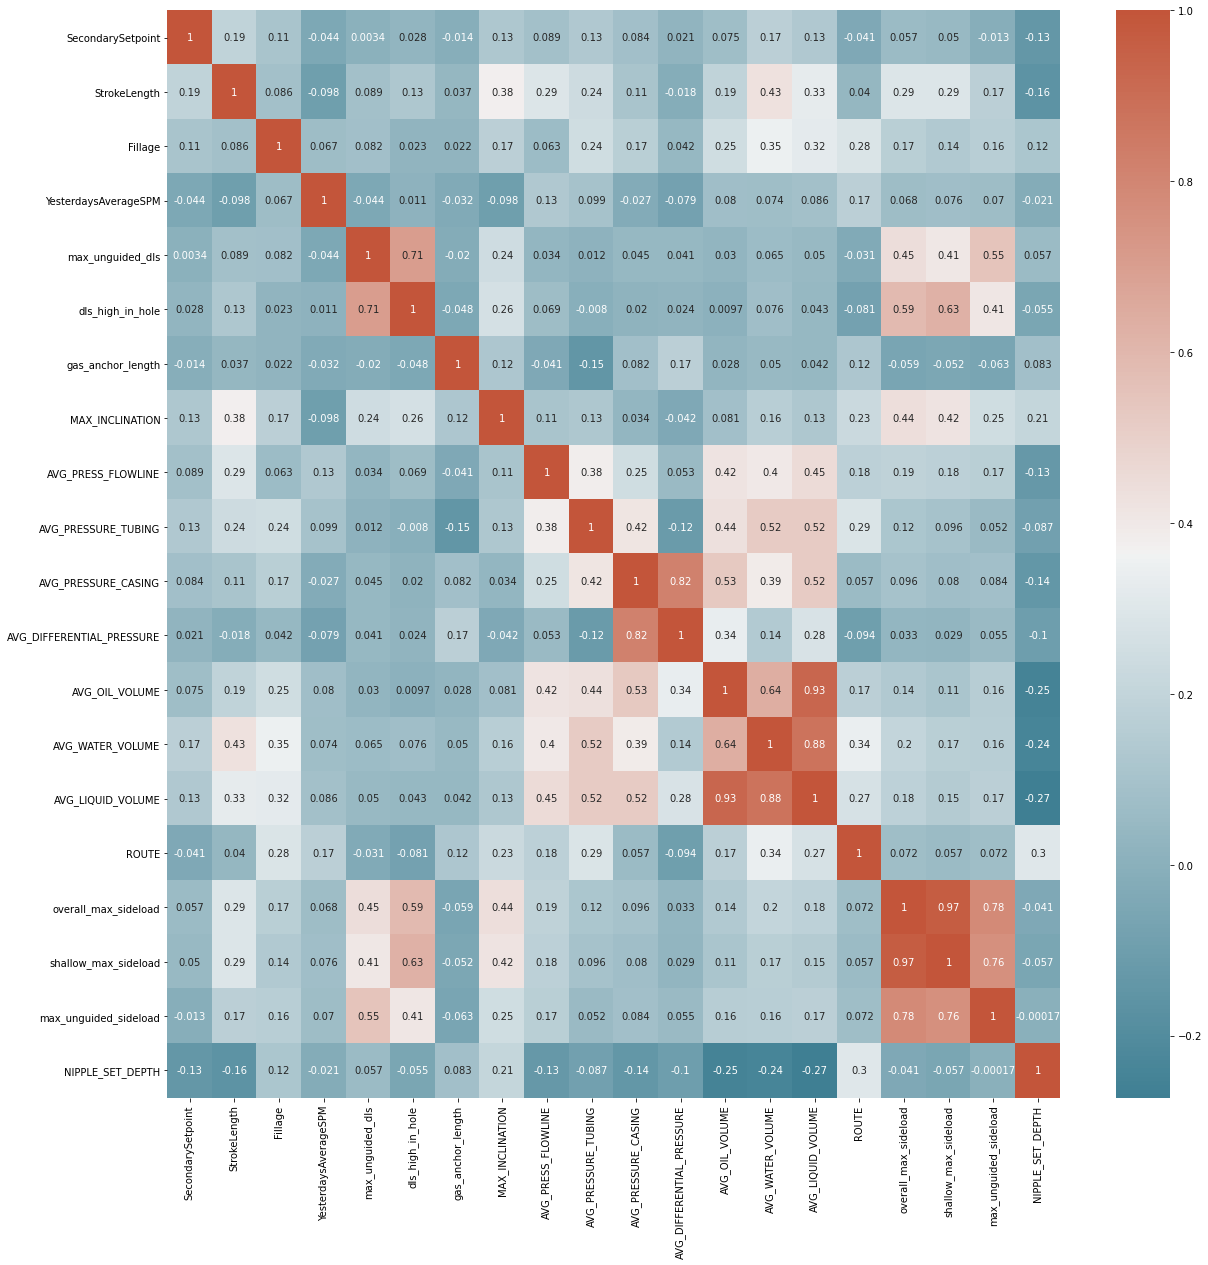

In [482]:
corr = rpdf_cleaned.corr()# plot the heatmap
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

#### Make Pairplots

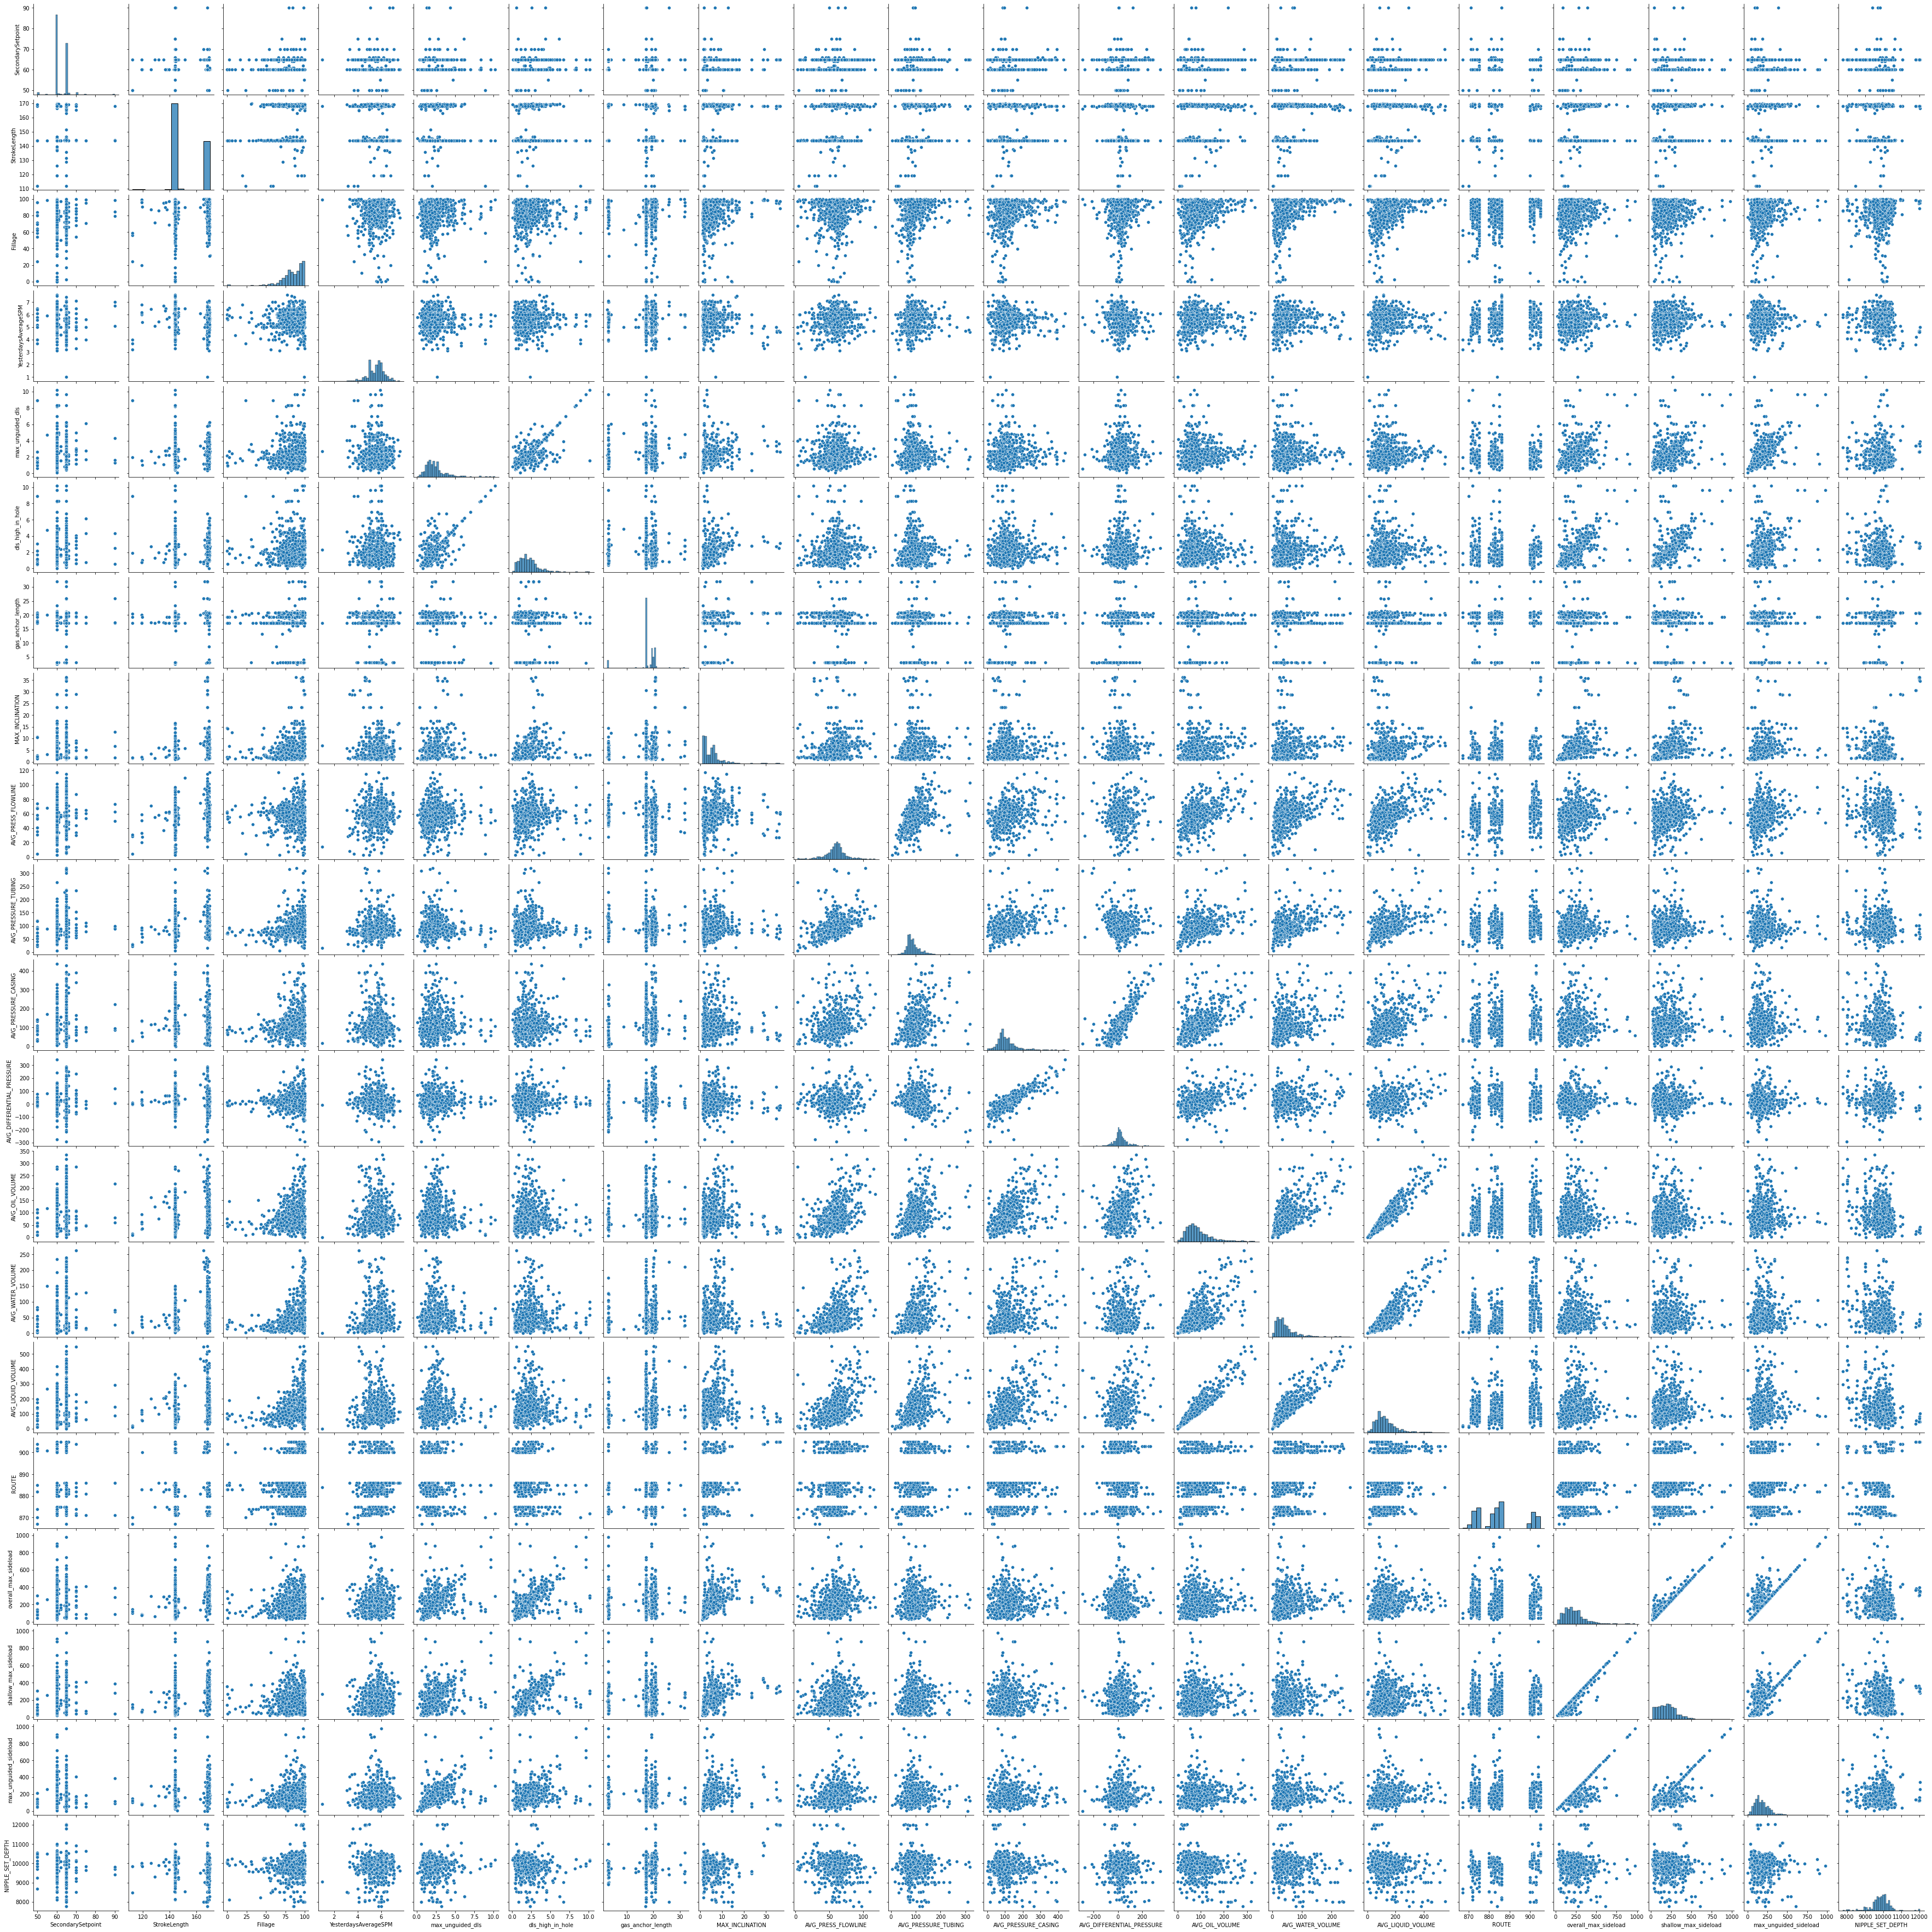

In [484]:
sns.pairplot(rpdf_cleaned.select_dtypes(include=[np.float64, np.int64]))